Problem Statement

The task involves classifying SMS messages as either spam or ham (non-spam). This is a crucial business problem, as efficient spam filtering can enhance user experience, prevent security threats, and improve overall communication reliability. Solving this problem benefits the company by ensuring users receive relevant messages, reduce the risk of phishing attacks, and maintaining a clean and secure messaging environment. The problem is formulated as an NLP task where the goal is to train a model to automatically classify messages into spam or ham categories.

Source of data: https://www.kaggle.com/datasets/abdallahwagih/spam-emails

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing nltk and text libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Load the dataset
df = pd.read_csv('spam.csv')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preprocessing

In [4]:
# Check for NaN values in the 'email' column
df['Message_length'] = df['Message'].apply(lambda x: len(x.split()) if isinstance(x, str) else np.nan)

"""We create a new feature ('Message_length') in the DataFrame that represents the length of each text message in terms of the number of words. We use np.nan for non-string values to indicate missing or undefined data. The code creates an additional column which we’ll use for further analysis and handle messages that are not properly formatted as strings."""

"We create a new feature ('Message_length') in the DataFrame that represents the length of each text message in terms of the number of words. We use np.nan for non-string values to indicate missing or undefined data. The code creates an additional column which we’ll use for further analysis and handle messages that are not properly formatted as strings."

In [5]:
# Feature Engineering
df['Message_word_count'] = df['Message'].apply(lambda x: len(x.split()))  # Number of words in the message
df['Message_avg_word_length'] = df['Message'].apply(lambda x: np.mean([len(word) for word in x.split()]))  # Average word length
df['Message_has_digits'] = df['Message'].apply(lambda x: any(c.isdigit() for c in x))  # Binary feature indicating if the message contains digits
df['Message_has_exclamation'] = df['Message'].apply(lambda x: '!' in x)  # Binary feature indicating if the message contains an exclamation mark
df['Message_has_link'] = df['Message'].apply(lambda x: 'http' in x or 'www' in x)  # Binary feature indicating if the message contains a link
df['Message_num_len'] = df['Message'].apply(lambda x: sum(c.isdigit() for c in x))  # Number of numeric characters
df['Message_punct_count'] = df['Message'].apply(lambda x: sum(c in set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~') for c in x))  # Punctuation count
df['Message_upper_ratio'] = df['Message'].apply(lambda x: sum(c.isupper() for c in x) / len(x) if len(x) > 0 else 0)

# Display the head of the DataFrame with the new features
print(df.head())

"""We perform feature engineering to capture insights about the emails such as their length, composition, and the presence of specific elements like digits, exclamation marks, and links. This is to help the model learn to distuish between spam and ham messages."""

  Category                                            Message  Message_length  \
0      ham  Go until jurong point, crazy.. Available only ...              20   
1      ham                      Ok lar... Joking wif u oni...               6   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...              28   
3      ham  U dun say so early hor... U c already then say...              11   
4      ham  Nah I don't think he goes to usf, he lives aro...              13   

   Message_word_count  Message_avg_word_length  Message_has_digits  \
0                  20                 4.600000               False   
1                   6                 4.000000               False   
2                  28                 4.571429                True   
3                  11                 3.545455               False   
4                  13                 3.769231               False   

   Message_has_exclamation  Message_has_link  Message_num_len  \
0                    False 

'We perform feature engineering to capture insights about the emails such as their length, composition, and the presence of specific elements like digits, exclamation marks, and links. This is to help the model learn to distuish between spam and ham messages.'

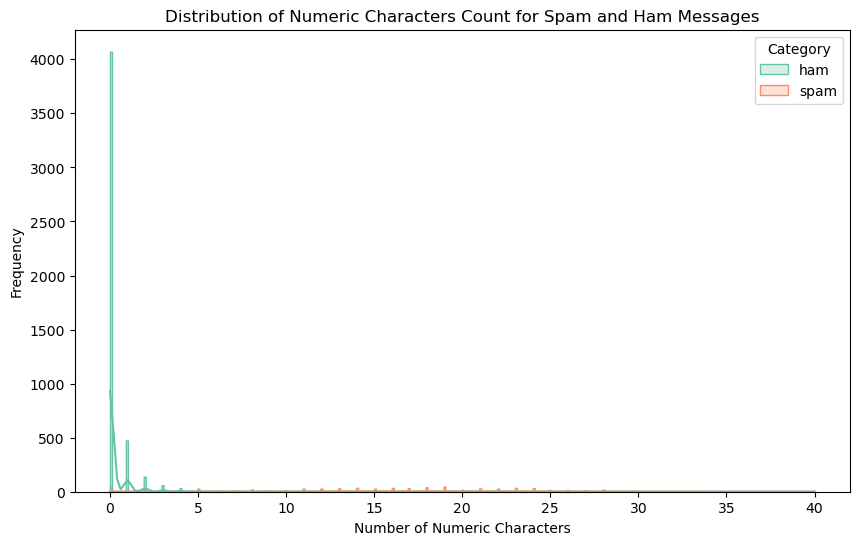

         Message_num_len                                                  
                   count       mean       std  min   25%   50%   75%   max
Category                                                                  
ham               4825.0   0.305285  1.073319  0.0   0.0   0.0   0.0  23.0
spam               747.0  15.639893  8.603115  0.0  10.0  16.0  22.0  40.0


'We  visualize the distribution of the count of numeric characters in spam and ham messages to get a summary of the count of numeric characters for spam and ham messages. From the graph it is evident that most ham messages have a very low number of numeric characters, with the majority having none (as indicated by the 25th, 50th, and 75th percentiles all being 0). Spam messages, on the other hand, exhibit more variability in the number of numeric characters.'

In [6]:
# Visualize the distribution of numeric characters count for spam and ham messages
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Message_num_len', hue='Category', kde=True, element='step', palette='Set2')
plt.title('Distribution of Numeric Characters Count for Spam and Ham Messages')
plt.xlabel('Number of Numeric Characters')
plt.ylabel('Frequency')
plt.show()

# Display statistical summary for the new features
print(df[['Message_num_len', 'Category']].groupby('Category').describe())

"""We  visualize the distribution of the count of numeric characters in spam and ham messages to get a summary of the count of numeric characters for spam and ham messages. From the graph it is evident that most ham messages have a very low number of numeric characters, with the majority having none (as indicated by the 25th, 50th, and 75th percentiles all being 0). Spam messages, on the other hand, exhibit more variability in the number of numeric characters."""

In [7]:
# Explore the distribution of word lengths in spam and ham messages
df['Message_word_lengths'] = df['Message'].apply(lambda x: [len(word) for word in x.split()])
df['Average_word_length_per_message'] = df['Message_word_lengths'].apply(lambda x: np.mean(x) if x else 0)

# Display statistical summary for average word lengths in spam and ham messages
average_word_lengths_summary = df[['Average_word_length_per_message', 'Category']].groupby('Category').describe()
print("Statistical Summary for Average Word Lengths:")
print(average_word_lengths_summary)

""" Next we proceed to check the average word length of ham and spam messages. This will help the modle distinguish between ham and spam messages. Ham messages have an average word length that ranges from 1.5 to 49, with a mean around 4.17 while spam messages have an average word length that ranges from 3.33 to 17.33, with a mean around 4.97. This shows that spam messages tend to have a slightly higher average word length compared to ham messages.""" 

Statistical Summary for Average Word Lengths:
         Average_word_length_per_message                                     \
                                   count      mean       std       min  25%   
Category                                                                      
ham                               4825.0  4.167562  1.126884  1.500000  3.6   
spam                               747.0  4.974508  1.005700  3.333333  4.4   

                                         
               50%       75%        max  
Category                                 
ham       4.000000  4.500000  49.000000  
spam      4.851852  5.371711  17.333333  


' Next we proceed to check the average word length of ham and spam messages. This will help the modle distinguish between ham and spam messages. Ham messages have an average word length that ranges from 1.5 to 49, with a mean around 4.17 while spam messages have an average word length that ranges from 3.33 to 17.33, with a mean around 4.97. This shows that spam messages tend to have a slightly higher average word length compared to ham messages.'

In [8]:
# Explore the most common words in spam and ham messages
from collections import Counter
from wordcloud import WordCloud

spam_messages = ' '.join(df[df['Category'] == 'spam']['Message'])
ham_messages = ' '.join(df[df['Category'] == 'ham']['Message'])

spam_word_frequencies = Counter(spam_messages.split())
ham_word_frequencies = Counter(ham_messages.split())

# Display the most common words in spam and ham messages
print("\nTop 10 Most Common Words in Spam Messages:")
print(spam_word_frequencies.most_common(10))
print("\nTop 10 Most Common Words in Ham Messages:")
print(ham_word_frequencies.most_common(10))

"""Next we check the most commonly used word in ham and spam messages. This will help our model quickly learn and differentiate between spam and ham messages."""


Top 10 Most Common Words in Spam Messages:
[('to', 604), ('a', 360), ('your', 187), ('or', 185), ('call', 183), ('the', 175), ('2', 169), ('for', 169), ('you', 164), ('is', 142)]

Top 10 Most Common Words in Ham Messages:
[('to', 1538), ('you', 1462), ('I', 1439), ('the', 1029), ('a', 977), ('i', 742), ('and', 739), ('in', 736), ('u', 651), ('is', 645)]


'Next we check the most commonly used word in ham and spam messages. This will help our model quickly learn and differentiate between spam and ham messages.'

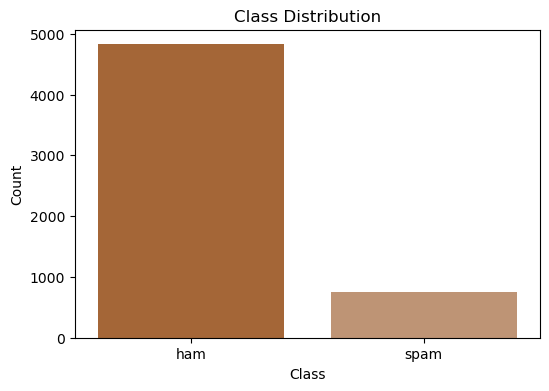

' To further improve our model we vizialize the distribution of ham and spam messages by creating a bar graph. The graph shows that ham messages are significantly higher (nearly 5ooo) in our dataset cempared to ham spam messages (nearly 1000).'

In [9]:
# Class distribution graph
plt.figure(figsize=(6, 4))
sns.set_palette(sns.light_palette("xkcd:copper",4, reverse=True))
sns.countplot(x='Category', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

""" To further improve our model we vizialize the distribution of ham and spam messages by creating a bar graph. The graph shows that ham messages are significantly higher (nearly 5ooo) in our dataset cempared to ham spam messages (nearly 1000)."""

C:\Users\HP\AppData\Local\Temp\ipykernel_10608\4134001789.py:5: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(data=df, x='Message_length', hue='Category', kde=True, element='step', palette=palette)


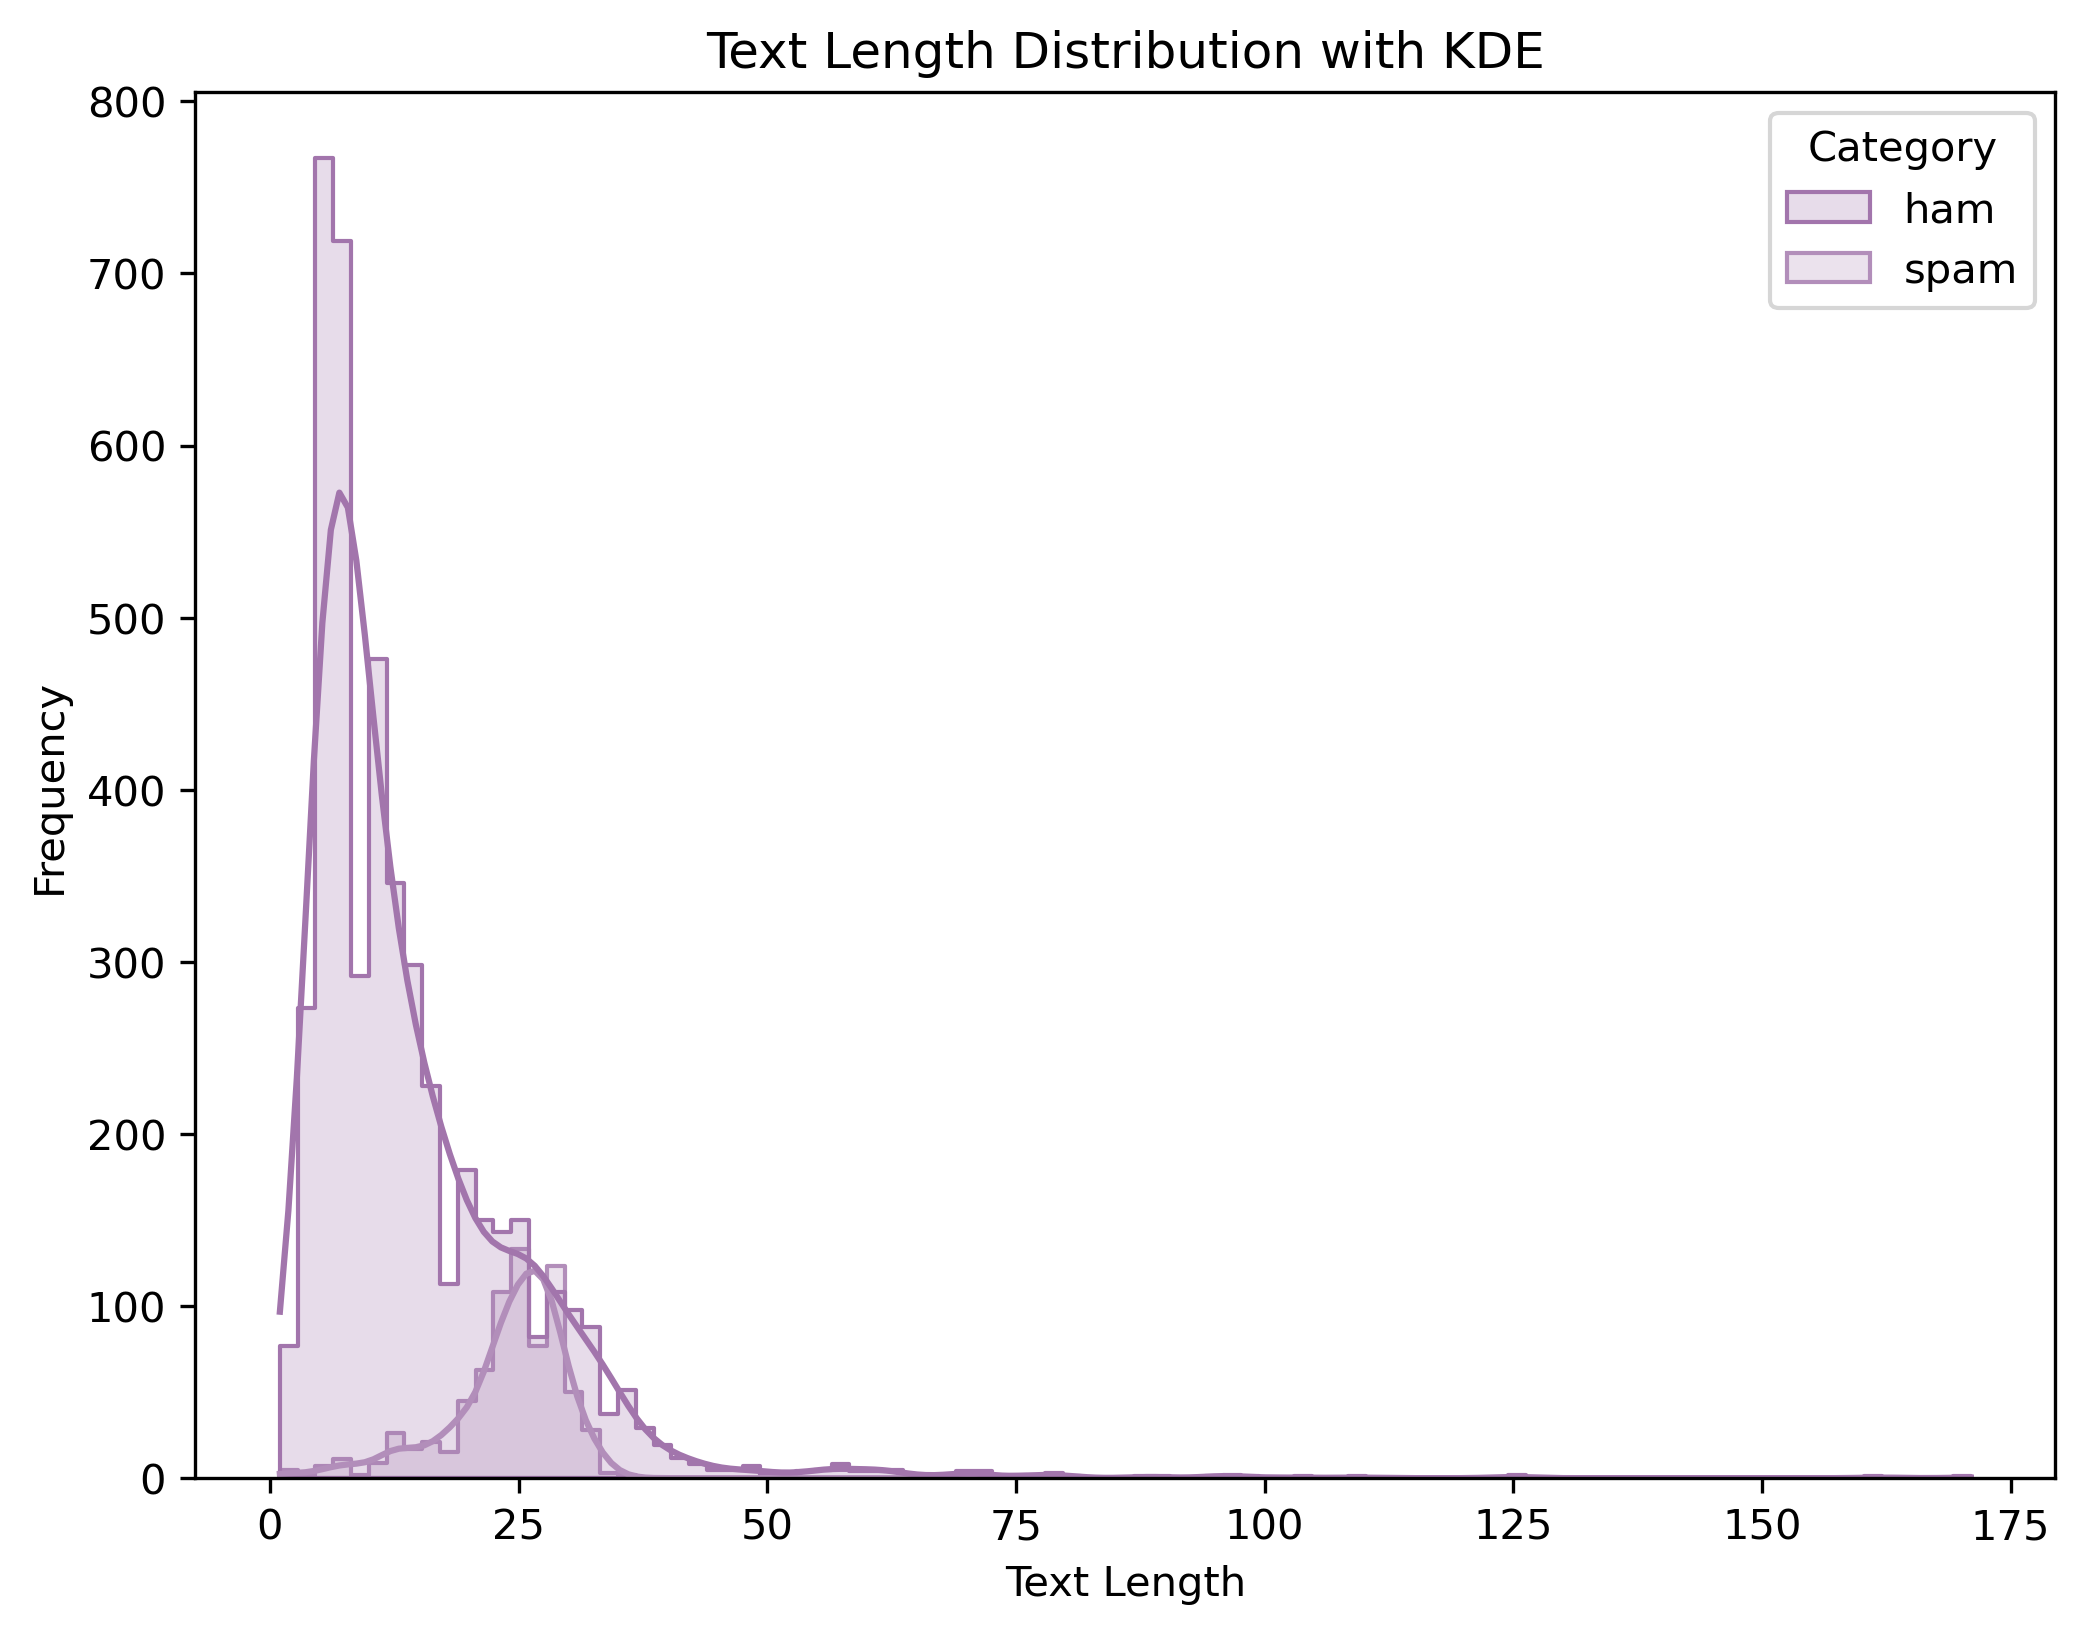

'Lastly we visualize the distribution of text lengths for both "ham" and "spam" messages in the dataset. The graph further proves that spam messages are longer than spam messages on average.'

In [10]:
# Text distribution graph
plt.figure(figsize=(8, 6), dpi=300)
palette = sns.light_palette("#a275ac", reverse=True)
sns.set_palette(palette)
sns.histplot(data=df, x='Message_length', hue='Category', kde=True, element='step', palette=palette)
plt.title('Text Length Distribution with KDE')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

"""Lastly we visualize the distribution of text lengths for both "ham" and "spam" messages in the dataset. The graph further proves that spam messages are longer than spam messages on average."""

# Model Preprocessing and training

In [11]:
# Preprocessing
nltk.download('stopwords')

def preprocess_text(text):
    words = word_tokenize(text)  # Tokenization
    words = [word.lower() for word in words if word.isalnum()]  # Convert to lowercase
    words = [word for word in words if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(words)  # Concatenate tokens

df['Message'] = df['Message'].apply(preprocess_text)

""" We break down text into tokens and convert each word to lowercase so as to ensure that the model doesn't treat the same word in different cases as different features. We then remove stopwords from the list of words as they don't carry much meaning and join the preprocessed words into a string so that we have a clean and preprocessed text for modelling."""

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


" We break down text into tokens and convert each word to lowercase so as to ensure that the model doesn't treat the same word in different cases as different features. We then remove stopwords from the list of words as they don't carry much meaning and join the preprocessed words into a string so that we have a clean and preprocessed text for modelling."

In [12]:
# Vectorization
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Message'])

In [13]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(vectors, df['Category'], random_state=42)

"""We split the data into train and test to check our models performance on unseen data. The training set is used to train the model, while the testing set is used to evaluate how well the model generalizes to new, unseen data."""

'We split the data into train and test to check our models performance on unseen data. The training set is used to train the model, while the testing set is used to evaluate how well the model generalizes to new, unseen data.'

In [14]:
# Model Training and Evaluation using GridSearchCV
models = {
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [5, 10, 15]}
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {'alpha': [0.1, 0.2, 0.05]}
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {'max_depth': [5, 10, 15]}
    },
    'SVC': {
        'model': SVC(),
        'params': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1.0, 0.1, 0.01]}
    },
}

scores = []

# Train and evaluate each model
for model_name, mp in models.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
    
""" We train and evaluate the model using four different machine learning models using using GridSearchCV for hyperparameter tuning. We aim to find the best hyperparameters for each model and assess their performance on our dataset."""

' We train and evaluate the model using four different machine learning models using using GridSearchCV for hyperparameter tuning. We aim to find the best hyperparameters for each model and assess their performance on our dataset.'

In [15]:
# Displaying the results
for score in scores:
    print(f"Model: {score['model']}")
    print(f"Best Score: {score['best_score']}")
    print(f"Best Parameters: {score['best_params']}")
    
"""This step is to evaluate the different models and see which performs the best based on their accuracy in classifying messages as either spam or ham. Based on the results it's evident that Multinomial Naive Bayes model achieved the highest accuracy in classifying ham and spam messages at 97.99% while worst model is K-Nearest Neighbors Classifier model had the lowest accuracy among the evaluated models at 89.20%.""" 

Model: KNeighborsClassifier
Best Score: 0.8920780448672033
Best Parameters: {'n_neighbors': 5}
Model: MultinomialNB
Best Score: 0.9798997220869268
Best Parameters: {'alpha': 0.2}
Model: RandomForestClassifier
Best Score: 0.9133736355041113
Best Parameters: {'max_depth': 15}
Model: SVC
Best Score: 0.9755909234163254
Best Parameters: {'gamma': 1.0, 'kernel': 'linear'}


"This step is to evaluate the different models and see which performs the best based on their accuracy in classifying messages as either spam or ham. Based on the results it's evident that Multinomial Naive Bayes model achieved the highest accuracy in classifying ham and spam messages at 97.99% while worst model is K-Nearest Neighbors Classifier model had the lowest accuracy among the evaluated models at 89.20%."

In [21]:
# Selecting the best model
best_model_name = max(scores, key=lambda x: x['best_score'])['model']
best_model_params = max(scores, key=lambda x: x['best_score'])['best_params']
best_model = models[best_model_name]['model'].set_params(**best_model_params)
best_model.fit(X_train, y_train)

MultinomialNB(alpha=0.2)

In [23]:
""" Next we write a code, as shown above, that will choose the best model based on the above results. The Multinomial Naive Bayes model achieved the highest score with a hyperparameter tuning of alpha=0.2 among the different models evaluated."""

' Next we write a code, as shown above, that will choose the best model based on the above results. The Multinomial Naive Bayes model achieved the highest score with a hyperparameter tuning of alpha=0.2 among the different models evaluated.'

In [17]:
# Predictions on the test set
y_pred = best_model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)

""" Next step is to make predictions on the test set using the best model selected above and calculating its accuracy score. A higher accuracy score suggests that the model is better at correctly classifying ham and spam messages while a lower accuracy score indicates a lower level of accuracy in classifying these messages.""" 

' Next step is to make predictions on the test set using the best model selected above and calculating its accuracy score. A higher accuracy score suggests that the model is better at correctly classifying ham and spam messages while a lower accuracy score indicates a lower level of accuracy in classifying these messages.'

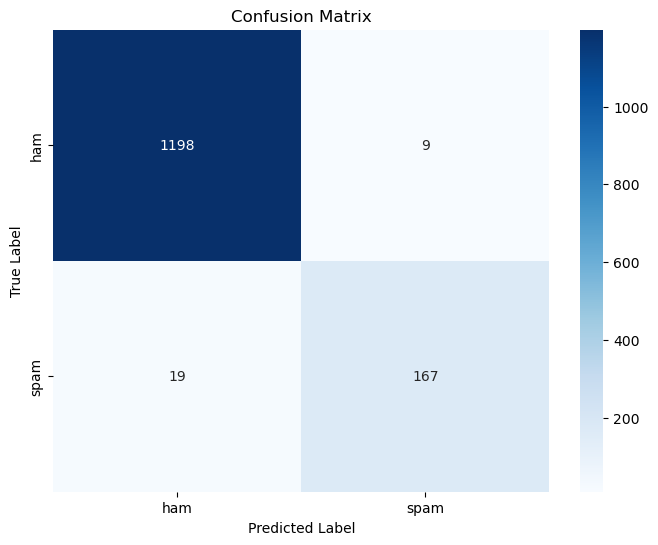

Best Model: MultinomialNB
Best Parameters: {'alpha': 0.2}
Accuracy Score: 0.9798994974874372
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1207
        spam       0.95      0.90      0.92       186

    accuracy                           0.98      1393
   macro avg       0.97      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



'The model further checks other accuracy metrics to evaluate the best model chosen. The best model is Multinomial Naive Bayes model which achieved the highest performance in classifying ham and spam messages at 97.98%. The precision for ham messages is 98% indicating that 98% of the messages classified as ham were actually ham while 95% of spam messages were correctly classified as spam. From F1 score which is the weighted avarage of both the Precisin and recall, the model correctly classified ham messages at 99% and spam messages at 92%. This meas that our model is working well even with the unseen data.'

In [18]:
# Checking other accuracy metrics
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Displaying the results
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_model_params}")
print(f"Accuracy Score: {accuracy}")
print("Classification Report:\n", classification_rep)

"""The model further checks other accuracy metrics to evaluate the best model chosen. The best model is Multinomial Naive Bayes model which achieved the highest performance in classifying ham and spam messages at 97.98%. The precision for ham messages is 98% indicating that 98% of the messages classified as ham were actually ham while 95% of spam messages were correctly classified as spam. From F1 score which is the weighted avarage of both the Precisin and recall, the model correctly classified ham messages at 99% and spam messages at 92%. This meas that our model is working well even with the unseen data."""

In [19]:
# Predictions on the test set
y_pred = best_model.predict(X_test)

# Precision, Recall, and F1 Score for spam class
spam_precision = precision_score(y_test, y_pred, pos_label='spam')
spam_recall = recall_score(y_test, y_pred, pos_label='spam')
spam_f1 = f1_score(y_test, y_pred, pos_label='spam')

print("Metrics for Spam Class:")
print(f"Precision: {spam_precision}")
print(f"Recall: {spam_recall}")
print(f"F1 Score: {spam_f1}")

"""Next we make predictions on the test set specifically for the spam class. The model demonstrates strong performance in identifying spam messages while minimizing false positives (ham messages classified as spam), as evidenced by high precision, recall, and F1 score for the spam class on the test set."""

Metrics for Spam Class:
Precision: 0.9488636363636364
Recall: 0.8978494623655914
F1 Score: 0.9226519337016574


'Next we make predictions on the test set specifically for the spam class. The model demonstrates strong performance in identifying spam messages while minimizing false positives (ham messages classified as spam), as evidenced by high precision, recall, and F1 score for the spam class on the test set.'

In [20]:
# Predictions on the test set
y_pred = best_model.predict(X_test)

# Precision, Recall, and F1 Score for ham class
ham_precision = precision_score(y_test, y_pred, pos_label='ham')
ham_recall = recall_score(y_test, y_pred, pos_label='ham')
ham_f1 = f1_score(y_test, y_pred, pos_label='ham')

print("\nMetrics for Ham Class:")
print(f"Precision: {ham_precision}")
print(f"Recall: {ham_recall}")
print(f"F1 Score: {ham_f1}")

"""Next we make predictions on the test set specifically for the Ham class. the model performs well in correctly identifying and classifying "ham" messages, as evidenced by the high precision, recall, and F1 score for the "ham" class."""


Metrics for Ham Class:
Precision: 0.9843878389482333
Recall: 0.9925434962717481
F1 Score: 0.9884488448844884


'Next we make predictions on the test set specifically for the Ham class. the model performs well in correctly identifying and classifying "ham" messages, as evidenced by the high precision, recall, and F1 score for the "ham" class.'

In conclusion, the model demonstrates high accuracy in differentiating between ham and spam messages. It achieves a good trade-off between precision (avoiding false positives) and recall (capturing actual positives).

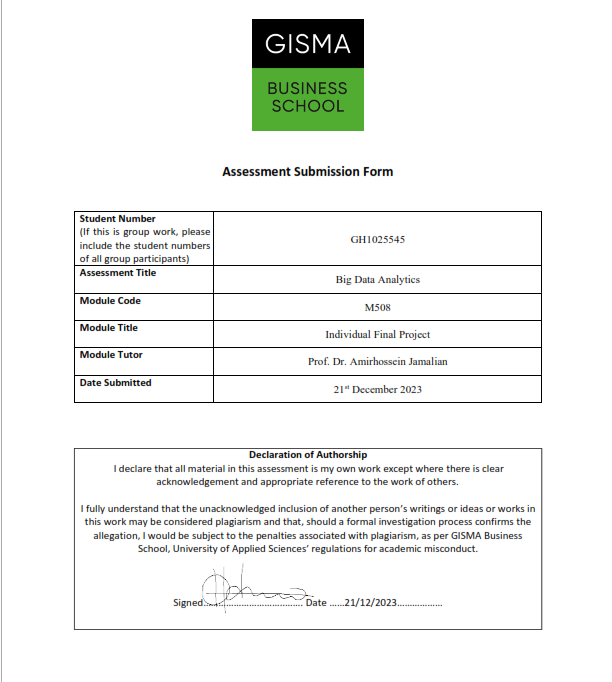